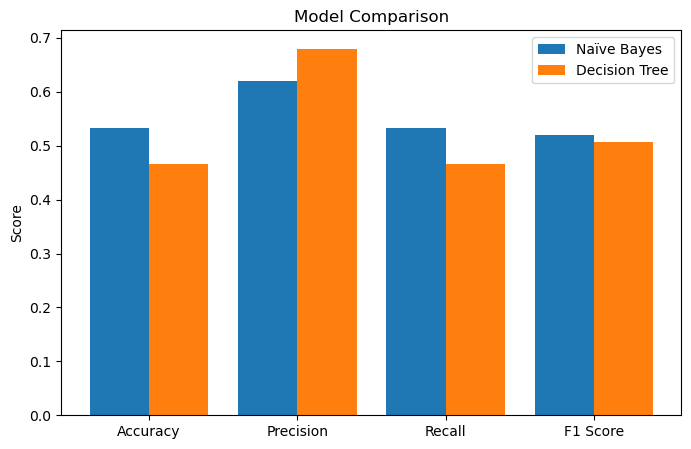

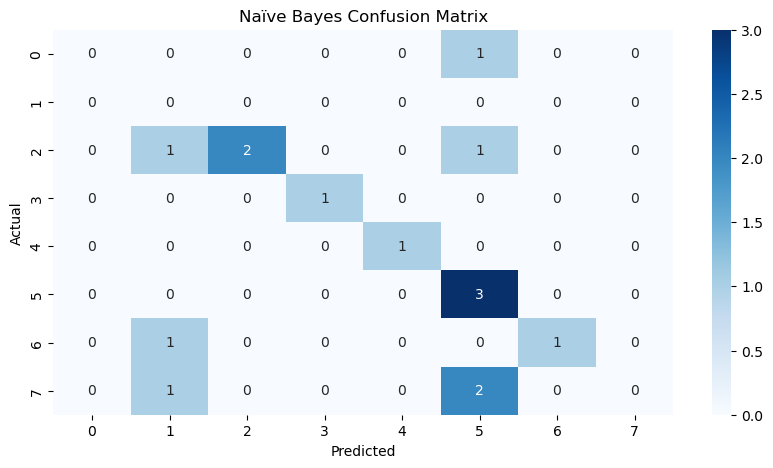

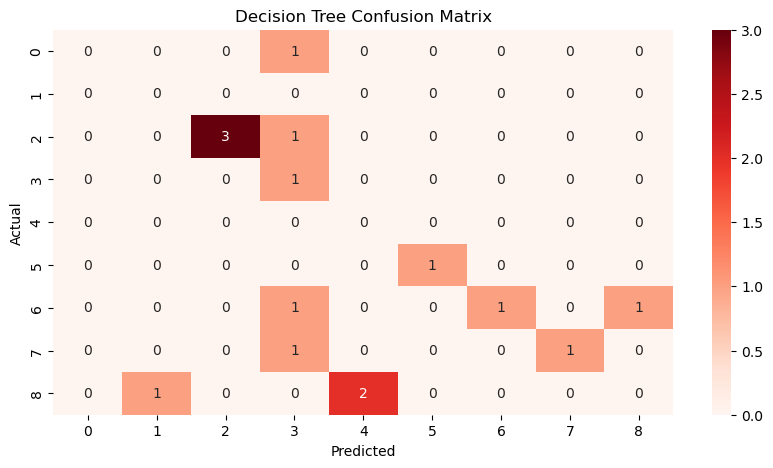

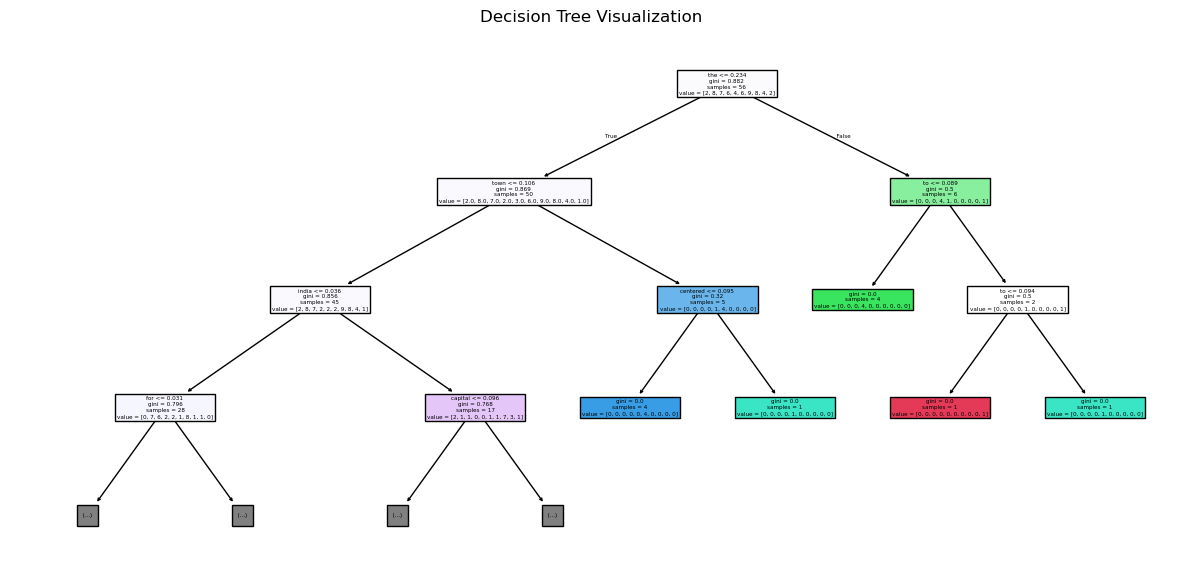

Enter the number of descriptions (1-3):  2
Enter description 1:  people
Enter description 2:  temple
Enter the preferred month (1-12):  6



Naïve Bayes Recommendations:
                  City  Rating
0            Gangtok       4.6
1            Udaipur       4.6
2  Andaman and Nicobar     4.6
3           Srinagar       4.2
4           Amritsar       4.7

Decision Tree Recommendations:
                  City  Rating
0            Gangtok       4.6
1            Udaipur       4.6
2            Gulmarg       4.4
3               Agra       4.9
4  Andaman and Nicobar     4.6


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)

def preprocess_data(df):
    descriptions = df["About the city (long Description)"].fillna("")
    df["Rating"] = pd.to_numeric(df["Rating"], errors='coerce')
    df["Rating"] = df["Rating"].fillna(df["Rating"].median())
    df["Best Month"] = df["Best Time to visit"].str.extract(r'(?i)(January|February|March|April|May|June|July|August|September|October|November|December)')
    month_map = {m: i+1 for i, m in enumerate(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])}
    df["Best Month"] = df["Best Month"].map(month_map)
    return descriptions, df["Rating"], df

def train_models(descriptions, ratings):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(ratings)
    X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2, random_state=42)
    
    nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    nb_model.fit(X_train, y_train)
    y_pred_nb = nb_model.predict(X_test)
    
    dt_model = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(max_depth=10))
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)
    
    metrics = {
        "Accuracy": [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_dt)],
        "Precision": [precision_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                      precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)],
        "Recall": [recall_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                   recall_score(y_test, y_pred_dt, average='weighted', zero_division=0)],
        "F1 Score": [f1_score(y_test, y_pred_nb, average='weighted', zero_division=0),
                     f1_score(y_test, y_pred_dt, average='weighted', zero_division=0)]
    }
    
    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics))
    plt.bar(x - 0.2, [metrics[m][0] for m in metrics], 0.4, label="Naïve Bayes")
    plt.bar(x + 0.2, [metrics[m][1] for m in metrics], 0.4, label="Decision Tree")
    plt.xticks(x, metrics.keys())
    plt.ylabel("Score")
    plt.title("Model Comparison")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt="d", cmap="Blues")
    plt.title("Naïve Bayes Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Decision Tree Confusion Matrix Heatmap
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="Reds")
    plt.title("Decision Tree Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Decision Tree Visualization
    feature_names = dt_model.named_steps["tfidfvectorizer"].get_feature_names_out()
    plt.figure(figsize=(15, 7))
    plot_tree(dt_model.named_steps["decisiontreeclassifier"], filled=True, feature_names=feature_names, max_depth=3)
    plt.title("Decision Tree Visualization")
    plt.show()
    
    return nb_model, dt_model, label_encoder

def recommend_cities(nb_model, dt_model, label_encoder, df):
    num_descriptions = int(input("Enter the number of descriptions (1-3): "))
    descriptions = [input(f"Enter description {i+1}: ") for i in range(num_descriptions)]
    month = int(input("Enter the preferred month (1-12): "))
    
    input_text = " ".join(descriptions)
    nb_pred = nb_model.predict_proba([input_text])
    dt_pred = dt_model.predict_proba([input_text])
    
    predicted_ratings_nb = label_encoder.inverse_transform(np.argsort(nb_pred[0])[-5:][::-1])
    predicted_ratings_dt = label_encoder.inverse_transform(np.argsort(dt_pred[0])[-5:][::-1])
    
    recommended_cities_nb = df[df["Rating"].isin(predicted_ratings_nb)][["City", "Rating"]].head(5).reset_index(drop=True)
    recommended_cities_dt = df[df["Rating"].isin(predicted_ratings_dt)][["City", "Rating"]].head(5).reset_index(drop=True)
    
    if recommended_cities_nb.empty:
        print("No recommendation, but these are the most nearest cities:")
        recommended_cities_nb = df.sort_values(by="Rating", ascending=False)[["City", "Rating"]].head(5)
    if recommended_cities_dt.empty:
        print("No recommendation, but these are the most nearest cities:")
        recommended_cities_dt = df.sort_values(by="Rating", ascending=False)[["City", "Rating"]].head(5)
    
    print("\nNaïve Bayes Recommendations:")
    print(recommended_cities_nb)
    print("\nDecision Tree Recommendations:")
    print(recommended_cities_dt)

df = pd.read_csv("holidify.csv")
descriptions, ratings, df = preprocess_data(df)
nb_model, dt_model, label_encoder = train_models(descriptions, ratings)
recommend_cities(nb_model, dt_model, label_encoder, df)